# Import necessary python lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
with open("x28.txt") as f:
    data = []
    content = f.readlines()[72:]
    for line in content:
        line  = line.strip()
        row = [float(i) for i in (line.split())[1:]]
        data.append(row)
    data = np.array(data)

# Get data

In [3]:
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,36.0,27.0,71.0,8.1,3.34,11.4,81.5,3243.0,8.8,42.6,11.7,21.0,15.0,59.0,59.0,921.870
1,35.0,23.0,72.0,11.1,3.14,11.0,78.8,4281.0,3.6,50.7,14.4,8.0,10.0,39.0,57.0,997.875
2,44.0,29.0,74.0,10.4,3.21,9.8,81.6,4260.0,0.8,39.4,12.4,6.0,6.0,33.0,54.0,962.354
3,47.0,45.0,79.0,6.5,3.41,11.1,77.5,3125.0,27.1,50.2,20.6,18.0,8.0,24.0,56.0,982.291
4,43.0,35.0,77.0,7.6,3.44,9.6,84.6,6441.0,24.4,43.7,14.3,43.0,38.0,206.0,55.0,1071.289


In [4]:
X = data[:, :-1]
Y = data[:, -1]
m = X.shape[0]
n = X.shape[1]

## Data description

In [5]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
print("Number of samples m =", m)
print("Number of features n =", n)

Shape of X: (60, 15)
Shape of Y: (60,)
Number of samples m = 60
Number of features n = 15


In [6]:
def plot_data(X, Y):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax.plot(X[:, 1], Y, 'o')
    plt.show()

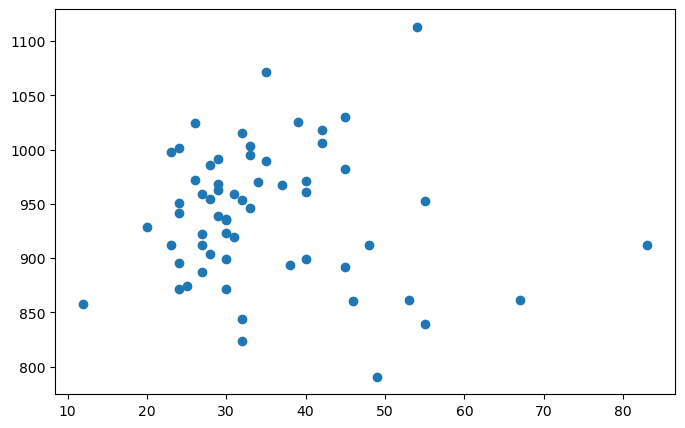

In [7]:
plot_data(X, Y)

<Axes: >

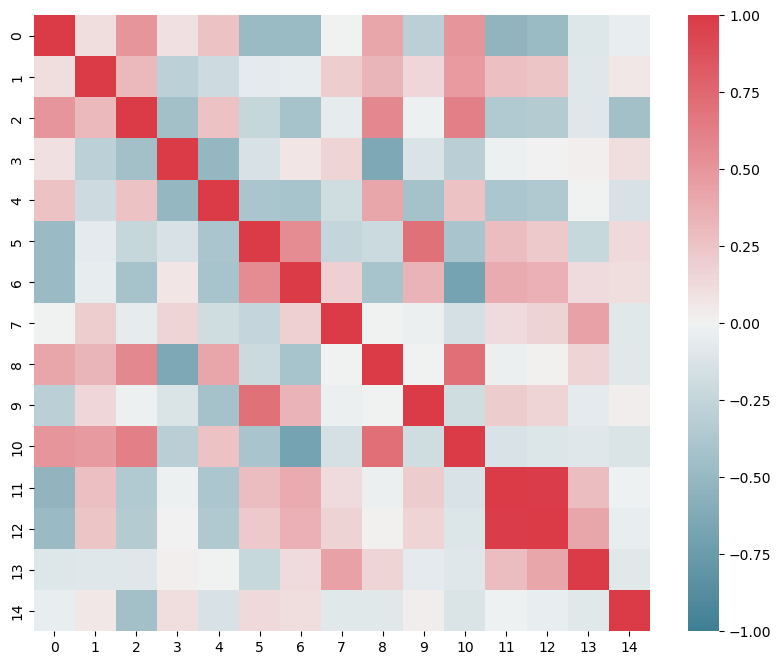

In [8]:
df = pd.DataFrame(X)
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

# Normalize data

In [9]:
def normalize_and_add_ones(X):
    X_max = np.max(X, axis = 0)
    X_min = np.min(X, axis = 0)
    X_range = X_max - X_min
    X_normalized = (X - X_min) / (X_range)
    ones = np.ones((X_normalized.shape[0]))
    return np.column_stack((ones, X_normalized))

In [10]:
X = normalize_and_add_ones(X)

# Building model

In [11]:
class RidgeRegression:
    def __init__(self) -> None:
        pass
    def fit(self, X_train, Y_train, LAMBDA):
        assert len(X_train.shape) == 2 and X_train.shape[0] == Y_train.shape[0]
        W = np.linalg.inv(X_train.T.dot(X_train) \
             + LAMBDA * np.identity(X_train.shape[1])).dot(X_train.T).dot(Y_train)
        # print(W)
        return W
    def predict(self, W, X_new):
        X_new = np.array(X_new)
        return W.dot(X_new.T)
    def compute_RSS(self, Y_new, Y_pred):
        m = Y_new.shape[0]
        loss = 1/m * (np.sum((Y_new - Y_pred)**2))
        return loss
    def get_the_best_LAMBDA(self, X_train, Y_train):
        def cross_validation(num_folds, LAMBDA):
            # get the index of all rows in the table
            row_ids = np.array(range(X_train.shape[0]))
            # valid end is the last index to get a valid split
            valid_end = len(row_ids) - len(row_ids) % num_folds
            valid_ids_set = np.split(row_ids[:valid_end], num_folds)
            # append the last index set which is not included in valid split above
            valid_ids_set.append(row_ids[valid_end:])
            # i-th training set may contain all number index k such that k not in i-th valid_ids_set
            train_ids_set = [[k for k in row_ids if k not in valid_ids_set[i]] for i in range (num_folds)]
            avg_RSS = 0
            for i in range (num_folds):
                valid_part = {"X": X_train[valid_ids_set[i]], "Y": Y_train[valid_ids_set[i]]}
                train_part = {"X": X_train[train_ids_set[i]], "Y": Y_train[train_ids_set[i]]}
                W = self.fit(train_part["X"], train_part["Y"], LAMBDA)
                Y_pred = self.predict(W, valid_part["X"])
                avg_RSS = avg_RSS + self.compute_RSS(valid_part["Y"], Y_pred)
            return avg_RSS/(num_folds)
            
        def range_scan(best_LAMBDA, minimum_RSS, LAMBDA_values):
            for LAMBDA in LAMBDA_values:
                RSS = cross_validation(5, LAMBDA)
                if RSS < minimum_RSS:
                    best_LAMBDA = LAMBDA
                    minimum_RSS = RSS
            return best_LAMBDA, minimum_RSS
        best_LAMBDA, minimum_RSS = range_scan(best_LAMBDA = 0, minimum_RSS = np.inf, LAMBDA_values = np.array(range(50)))
        # after finding temp best_lambda, we continously scan from smaller range around best_lambda
        # (max(0, best_lambda - 1), best_lambda + 1) with step = 0.001
        LAMBDA_values = [k * 1./1000 for k in range(max(0, (best_LAMBDA - 1)*1000, \
                        (best_LAMBDA+1)*1000, 1))]
        best_LAMBDA, minimum_RSS = range_scan(best_LAMBDA, minimum_RSS, LAMBDA_values)
        
        return best_LAMBDA

    def fit_minibatch_GD(self, X_train, Y_train, LAMBDA,
                learning_rate, num_epochs = 100, batch_size = 4):
        #set-up some important value.
        # m = number of datapoints, n = number of features                 
        m = X_train.shape[0]
        n = X_train.shape[1]
        epsilon = 1e-8
        # initialize the first value of W
        W = np.random.randn(n)
        #shuffle the dataset
        arr = np.array(range(m))
        np.random.shuffle(arr)
        X_train = X_train[arr]
        Y_train = Y_train[arr]
        loss = np.inf
        loss_history = []
        for epoch in range (num_epochs):
            # print("training epoch {}".format(epoch + 1))
            num_batchs = m // batch_size
            # print("number of batch:", num_batchs)
            for i in range(num_batchs):
                # print("{}-th batch".format(i+1))
                index = (i*batch_size)
                X_batch = X_train[index:index+batch_size]
                Y_batch = Y_train[index:index+batch_size]
                grad = (X_batch.T).dot(X_batch.dot(W) - Y_batch) + LAMBDA * W
                W = W - grad*learning_rate
            new_loss = self.compute_RSS(Y_train, X_train.dot(W))
            loss_history.append(new_loss)
            if abs(new_loss - loss) < epsilon:
                print("stop_loss =", abs(new_loss - loss))
                break
            loss = new_loss
        # print(loss_history)
        print("trained with {} epochs".format(epoch))
        return W, loss_history
    def fit_SGD(self, X_train, Y_train, LAMBDA,
                learning_rate, num_epochs = 100):
        return self.fit_minibatch_GD(X_train, Y_train, LAMBDA,
                learning_rate, num_epochs = 100, batch_size = 1)

In [12]:
def analysis_result(W, X_train, Y_train, model = RidgeRegression()):
    best_LAMBDA = model.get_the_best_LAMBDA(X_train, Y_train)
    print("=========== Best found LAMBDA ===========")
    print("LAMBDA =", best_LAMBDA)
    print("============= Weights found =============")
    print("W =", W)
    print("============ On training set ============")
    Y_pred = model.predict(W, X_train)
    RSS = model.compute_RSS(Y_train, Y_pred)
    print("RSS =", RSS)
    print("============ On test set ================")
    Y_pred = model.predict(W, X_test)
    RSS = model.compute_RSS(Y_test, Y_pred)
    print("RSS =", RSS)
    print("=========== Predicted label =============")
    print("Predicted Y =", Y_pred)

In [19]:
X_train, Y_train = X[:50], Y[:50]
X_test, Y_test = X[50:], Y[50:]
ridge_regression = RidgeRegression()
best_LAMBDA = ridge_regression.get_the_best_LAMBDA(X_train, Y_train)
W = ridge_regression.fit(X_train, Y_train, LAMBDA = best_LAMBDA)
analysis_result(W, X_train, Y_train)

=========== Best found LAMBDA ===========
LAMBDA = 0.002
============= Weights found =============
W = [1024.0681333    99.3869809  -177.04383589  -49.55069331 -109.45846309
  -83.23492889  -76.7044116   -23.40678042  106.84316576  113.55322975
   25.78665552   32.54535683 -443.10272843  460.01783432    4.47865685
   22.3217114 ]
============ On training set ============
RSS = 680.6112634833859
============ On test set ================
RSS = 1527.0698078029754
=========== Predicted label =============
Predicted Y = [877.39059783 921.33583769 931.7104582  893.81221771 993.93880571
 894.54583255 932.43571582 891.59941659 912.15753609 923.87639342]


In [20]:
m = X_train.shape[0]
W, loss_history = ridge_regression.fit_minibatch_GD(X_train, Y_train,
                                        LAMBDA = best_LAMBDA,
                                        num_epochs=1000,
                                        learning_rate = 0.03,
                                        batch_size=8)
analysis_result(W, X_train, Y_train)

trained with 999 epochs
=========== Best found LAMBDA ===========
LAMBDA = 0.002
============= Weights found =============
W = [ 926.34465333   58.3108839  -119.41928109  -14.68878624  -41.1678983
  -28.35331371  -61.80620914  -24.15976535   96.9218012   132.72165082
   30.0669835    23.26505277  -46.88236276   47.72606697   38.94476923
   37.77226569]
============ On training set ============
RSS = 833.785093596271
============ On test set ================
RSS = 1527.4755950538058
=========== Predicted label =============
Predicted Y = [ 880.89439553  930.55569792  931.13605815  906.57528117 1000.12965696
  896.45408451  932.06348251  899.62536761  937.18811129  932.12788465]


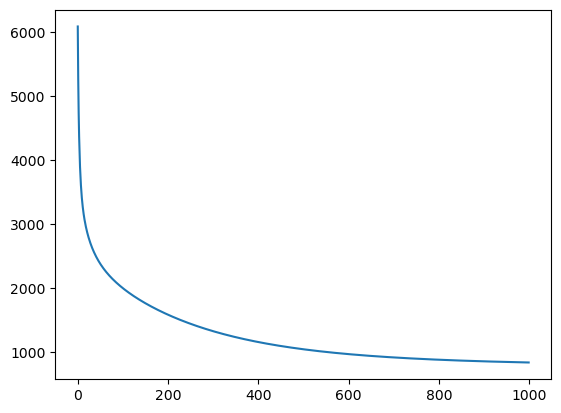

In [21]:
plt.plot(loss_history)

In [22]:
X_train, Y_train = X[:50], Y[:50]
X_test, Y_test = X[50:], Y[50:]
ridge_regression = RidgeRegression()
W, loss_history = ridge_regression.fit_SGD(X_train, Y_train, LAMBDA = best_LAMBDA, learning_rate=0.1)
analysis_result(W, X_train, Y_train)

trained with 99 epochs
=========== Best found LAMBDA ===========
LAMBDA = 0.002
============= Weights found =============
W = [613.04944133 111.82729278 -85.05316928  53.39161408  84.10848318
  97.51272125  41.60992844  15.47149698 145.88033211 125.31759851
  31.31512574  52.98711598  10.42809151  57.20640792  53.18488977
  75.03319166]
============ On training set ============
RSS = 2590.4976660242132
============ On test set ================
RSS = 3227.2327817994183
=========== Predicted label =============
Predicted Y = [ 927.87633107  996.4894328   933.5170407   930.44570065 1047.19507854
  925.70912742  977.56703437  973.90610842  970.89570192  982.46062253]


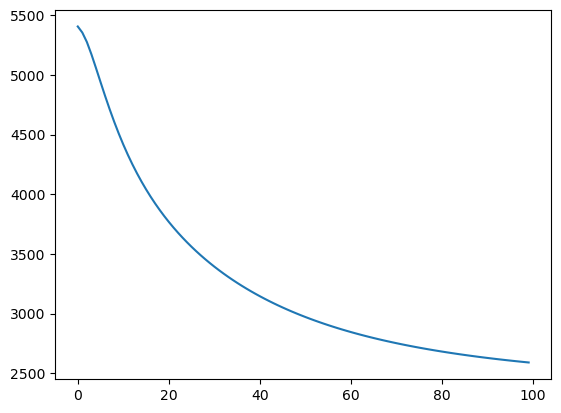

In [23]:
plt.plot(loss_history)